### Task 103: Integrate interest APS calculation from CPT liquidity pool in Rebasing token

* Make the the APS source configurable. The CPT pool being used to calculate the interest APS should be configurable for any CPT in the simulation.

* Being able to process only one source is sufficient. End goal is to be able to proportionally aggregate the interest APS from several sources. For example, the TCT may rebase using the supplies of T1 and T2 managed by the vault, including the interest rates for liquidity containing those assets. This may be a single pool that contains both tokens, and/or pools that contain only one of the assets.


In [1]:
import os
import copy
import numpy as np
import time
import math
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.cpt import Liquidity
from python.dev.token import RebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.interest.ips import ConstantIPS
from python.dev.math.interest import CompoundReturn

In [2]:
time0 = time.time()
N_TOKENS = 2

### Part A: Test IPS

In [3]:
APY = 0.1234567
TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
A0 = 10000
token_delta = 1000
time_delta = 1000

token = RebaseToken(TYPE_DEPOSIT_TOKEN)
addr = token.gen_address()
token.init_token(time0, addr)
token.add_event(Deposit(APY, A0, 0, addr))

In [4]:
token.add_event(Deposit(APY, token_delta, time_delta, addr))
last_state = token.get_state_series(addr).get_last_state()

A1 = last_state.get_balance() - token_delta
dt = last_state.get_event().get_time_delta() 

In [5]:
cIPS = ConstantIPS()
cReturn = CompoundReturn()
ips1 = cIPS.calc_ips_from_state(last_state)
ips2 = cIPS.calc_ips(A0, A1, dt)
r1 = cReturn.apply(A0,ConstantIPS.SECONDS_YEAR,ips1)
r2 = cReturn.apply(A0,ConstantIPS.SECONDS_YEAR,ips2)

print('Test 1: annual return -> {}'.format(r1 == A0*(APY+1)))
print('Test 2: annual return -> {}'.format(r2 == A0*(APY+1)))

Test 1: annual return -> True
Test 2: annual return -> True


### Part B: Simulation Run
* Initialize Rebasing/Rebasing Tokens

In [6]:
APY = 0.1
TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TOKEN = N_TOKENS * [None]
ADDR = N_TOKENS * [None]
deposit = 10000 

TOKEN[0] = RebaseToken(TYPE_DEPOSIT_TOKEN)
ADDR[0] = TOKEN[0].gen_address()
TOKEN[0].init_token(time0, ADDR[0])
TOKEN[0].add_event(Deposit(APY, deposit, 0, ADDR[0]))
   
TOKEN[1] = RebaseToken(TYPE_DEPOSIT_TOKEN)
ADDR[1] = TOKEN[1].gen_address()
TOKEN[1].init_token(time0, ADDR[1])
TOKEN[1].add_event(Deposit(APY, deposit, 0, ADDR[1]))
    
x = TOKEN[0].get_balance_deposits()
y = TOKEN[1].get_balance_deposits()

# Initialize Liquidity Pool
liq = Liquidity(x,y)

In [7]:
percent = 0.05
N = 250
prices_yx = N * [0]
prices_xy = N * [0]

for k in range(N):

    token_delta = TokenDeltaModel(1,100).apply() 
    time_delta = TimeDeltaModel().apply() 
    TOKEN[0].add_event(Deposit(APY, token_delta, time_delta, ADDR[0]))

    token_delta = TokenDeltaModel(1,100).apply() 
    time_delta = TimeDeltaModel().apply() 
    TOKEN[1].add_event(Deposit(APY, token_delta, time_delta, ADDR[1]))        
        
    T1_yield = TOKEN[0].get_state_series(ADDR[0]).get_last_state().get_yield()
    T2_yield = TOKEN[1].get_state_series(ADDR[1]).get_last_state().get_yield()
    
    T1_delta = TOKEN[0].get_state_series(ADDR[0]).get_last_state().get_delta()
    T2_delta = TOKEN[1].get_state_series(ADDR[1]).get_last_state().get_delta()
        
    x = TOKEN[0].get_balance_deposits()
    y = TOKEN[1].get_balance_deposits()

    liq.delta_x(T1_delta+T1_yield)
    liq.delta_y(T2_delta+T2_yield)     
    L = liq.calc()
    prices_yx[k] = liq.get_swap_price(Liquidity.YX_PRICE)  
    prices_xy[k] = liq.get_swap_price(Liquidity.XY_PRICE)
    
    if (k % int(N/(100*percent)) == 0):
        out_str = '[SIM {}]'.format(k)
        for k in range(N_TOKENS):
            amt = TOKEN[k].get_balance_deposits()
            out_str = out_str+' T{}: {:.2f}'.format(k+1,amt)
            
        print(out_str) 
        

[SIM 0] T1: 10244.80 T2: 10052.92
[SIM 50] T1: 15098.05 T2: 14781.28
[SIM 100] T1: 20874.62 T2: 20720.86
[SIM 150] T1: 26217.49 T2: 25405.12
[SIM 200] T1: 31135.91 T2: 31313.84


In [25]:
A0 = balance[1] + balance2[0]
A1 = balance[1] + balance2[0]

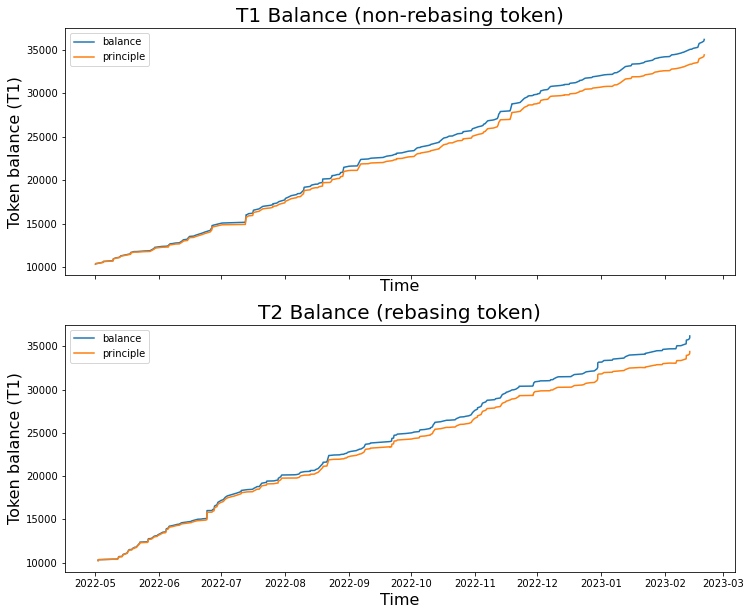

In [23]:
# Analyze Token balances

T1_states = TOKEN[0].get_state_series(ADDR[0])
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, T2_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (non-rebasing token)", fontsize=20)
T1_ax.set_ylabel("Token balance (T1)", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

T2_states = TOKEN[1].get_state_series(ADDR[1])
principle2 = T2_states.get_principle() 
balance2 = T2_states.get_balance() 
tSamp = T2_states.get_tstamp() 

principle2 = [principle2[k]*prices_xy[k] for k in range(N)]
balance2 = [balance2[k]*prices_xy[k] for k in range(N)]

T2_ax.plot(tSamp[1:], balance2, label='balance') 
T2_ax.plot(tSamp[1:], principle2, label='principle') 
T2_ax.set_title("T2 Balance (rebasing token)", fontsize=20)
T2_ax.set_ylabel("Token balance (T1)", fontsize=16)
T2_ax.set_xlabel('Time', fontsize=16)
T2_ax.legend()
